In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
#from keybert import KeyBERT
import yake
import string
import numpy as np

In [ ]:
sds_data = pd.read_csv('../data/sds_ds_text.csv')
sds_non_data = pd.read_csv('../data/sds_nds_text.csv')

## Generating keywords for Data Science Episodes

In [ ]:
sds_ds_processed = pd.DataFrame(sds_data.groupby(['episode_number', 'episode_name', 'length_episode', 'context_episode', 'guest_name', 'host_episode', 'episode_year'])['episode_split_text'].agg(lambda x: ' '.join(str(i) for i in x))).reset_index()

In [ ]:
sds_ds_processed

In [ ]:
# Remove episode 202 and 546 with no text in episode_split_text
#sds_processed = 
#sds_ds_processed[sds_ds_processed['episode_split_text'] == 'nan']#.reset_index(drop = True)

In [ ]:
# Function to clean the text 
def processed_text(text):  
    # Lowercase the text
    text = text.lower()
    # Remove punctuation from the text
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove digits from the text
    text = ''.join(char for char in text if not char.isdigit())
    return text

In [ ]:
sds_ds_processed['episode_split_text'] = sds_ds_processed['episode_split_text'].apply(processed_text)

In [ ]:
sds_ds_processed['episode_keywords'] = None

In [ ]:
# Function to generate 100 keywords per episode using Yake library to store keywords in one column as list
def yake_keyword_extractor(doc):
    global sds_ds_processed
    
    for i, episode_text in doc.iteritems():
        max_ngram_size = 3
        deduplication_threshold = 0.3
        windowSize = 1
        numOfKeywords = 100
        kw_extractor = yake.KeywordExtractor(n = max_ngram_size, dedupLim = deduplication_threshold , windowsSize = windowSize, top = numOfKeywords)
        keywords = kw_extractor.extract_keywords(episode_text)
        sds_ds_processed.at[i, 'episode_keywords'] = keywords

In [ ]:
yake_keyword_extractor(sds_ds_processed['episode_split_text'])

In [ ]:
sds_ds_processed

In [ ]:
def tuple_extractor(row):
    words = [t[0].replace(" ", "_") for t in row]
    return " ".join(words)

In [ ]:
sds_ds_processed['keywords'] = sds_ds_processed['episode_keywords'].apply(tuple_extractor)

In [ ]:
sds_ds_processed

In [ ]:
sds_ds_processed.to_csv('../data/sds_ds_keywords.csv', index = False)

## Generating keywords for non-Data Science Episodes

In [ ]:
sds_nds_processed = pd.DataFrame(sds_non_data.groupby(['episode_number', 'episode_name', 'length_episode', 'context_episode', 'guest_name', 'host_episode', 'episode_year'])['episode_split_text'].agg(lambda x: ' '.join(str(i) for i in x))).reset_index()

In [ ]:
sds_nds_processed['episode_split_text'] = sds_nds_processed['episode_split_text'].apply(processed_text)

In [ ]:
sds_nds_processed['episode_keywords'] = None

In [ ]:
# Function to generate 100 keywords per episode using Yake library to store keywords in one column as list
def yake_keyword_extractor(doc):
    global sds_nds_processed
    
    for i, episode_text in doc.iteritems():
        max_ngram_size = 3
        deduplication_threshold = 0.3
        windowSize = 1
        numOfKeywords = 100
        kw_extractor = yake.KeywordExtractor(n = max_ngram_size, dedupLim = deduplication_threshold , windowsSize = windowSize, top = numOfKeywords)
        keywords = kw_extractor.extract_keywords(episode_text)
        sds_nds_processed.at[i, 'episode_keywords'] = keywords

In [ ]:
yake_keyword_extractor(sds_nds_processed['episode_split_text'])

In [ ]:
sds_nds_processed['keywords'] = sds_nds_processed['episode_keywords'].apply(tuple_extractor)

In [ ]:
sds_nds_processed

In [ ]:
sds_nds_processed.to_csv('../data/sds_nds_keywords.csv', index = False)

### Count Vectorizer and Class-Based Tfidf

In [1]:
import scipy.sparse as sp
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.preprocessing import normalize

In [2]:
sds_ds_keywords = pd.read_csv('../data/sds_ds_keywords.csv')

keywords_per_class = sds_ds_keywords.groupby('context_episode')['keywords'].apply(' '.join).reset_index()

# Rename the columns to match the original code
keywords_per_class = keywords_per_class.rename(columns={'context_episode': 'Class', 'keywords': 'Document'})

<IPython.core.display.Javascript object>

In [19]:
keywords_per_class

,Class,Document
0,Artificial Intelligence,data_science_work governments_data_science sci...
1,Blockchain,exponential_business_models companies_yeah_exp...
2,Business,data_scientists_tend ’re_hiring_data mentor_ri...
3,Business Artificial Intelligence,n’t_feel_sick reality_yeah_yeah explain_compli...
4,Business Artificial Intelligence Database,data_architecture_data super_data_science your...
...,...,...
86,R Programming Python,data_science_yeah studio_yeah_youre yeah_yeah_...
87,R Programming Tableau Database Data Visualization,data_science_conference regional_operations_ma...
88,Tableau Data Visualization,tableau_user_group arkansas_tableau_user youre...
89,Tableau Database Data Visualization,data_science_yeah ’re_helping_people quickly_y...


In [3]:
class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """Learn the idf vector (global term weights) """
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X

In [4]:
# Create c-TF-IDF
count = CountVectorizer().fit_transform(keywords_per_class.Document)
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(keywords_per_class)).toarray()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# Create bag of words using count vectorizer
count_vectorizer = CountVectorizer().fit(keywords_per_class.Document)
count = count_vectorizer.transform(keywords_per_class.Document)
words = count_vectorizer.get_feature_names_out()

In [6]:
count_vectorizer.vocabulary_

{'data_science_work': 6475,
 'governments_data_science': 11407,
 'science_data_collection': 23570,
 'work_programmers_data': 30218,
 'left_brain_people': 15791,
 'people_indecipherable_things': 19756,
 've_read_bits': 29266,
 'unsupervised_learning_works': 28995,
 'taxpayers': 26826,
 '_money_governments': 5,
 'main_things_today': 16785,
 'show_notes_yeah': 24234,
 'arts_yeah_yay': 1458,
 'yeah_yay_good': 30687,
 'data_analytics_capabilitiesand': 6264,
 'departments_performing_business': 6933,
 'technical_left_brain': 26944,
 'university_studies_interesting': 28938,
 'tax_office_inaudible': 26822,
 'data': 6249,
 'providing_online_services': 21574,
 'good_bacteria_probiotic': 11103,
 'photography_sculpture_painting': 20107,
 'latest_technology_implement': 15533,
 'huge_competitive_edgeon': 12894,
 'lot': 16380,
 'inanimate_objects_anymore': 13518,
 'published_isaac_newton': 21648,
 'work': 30172,
 'subject_matter_experts': 26031,
 'high_low_close': 12515,
 'shen_henry_wang': 24110,
 'b

In [7]:
len(count_vectorizer.vocabulary_)

31155

In [8]:
count.shape

(91, 31155)

In [9]:
word_counts = pd.DataFrame({
    'words': count_vectorizer.get_feature_names_out(),
    'frequency': np.array(count.sum(axis = 0)).flatten()
})
word_counts.sort_values('frequency', ascending = False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,words,frequency
6249,data,368
30548,yeah,254
16380,lot,193
27743,time,189
24177,show,176
...,...,...
10769,gdpr_legal_services,1
10768,gdpr_global,1
10767,gdpr,1
10765,gdansk_university,1


In [10]:
word_counts[word_counts['frequency'] < 5]

,words,frequency
0,_affairs,1
1,_capacity_enabling,1
2,_digital,1
3,_guys,1
4,_hands,1
...,...,...
31150,zuckerberg_gray,1
31151,zuckerbergthe_fourth_mentor,1
31152,zurich,1
31153,zurich_in_switzerland,1


In [11]:
# class based tfidf
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(keywords_per_class)).toarray()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# find unique words in each class
unique_words_per_class = []
for i, class_docs in enumerate(keywords_per_class.Document):
    tfidf_scores = ctfidf[i]
    unique_word_indices = np.argsort(tfidf_scores)[-20:][::-1]  # index
    unique_words = [words[idx] for idx in unique_word_indices]  # feature name
    unique_words_per_class.append(unique_words)

class_unique_20 = pd.DataFrame({'Class': keywords_per_class.Class, 'unique_Words': unique_words_per_class})


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
class_unique_20

,Class,unique_Words
0,Artificial Intelligence,"[_affairs, facebook_apple, selfcontradictory_t..."
1,Blockchain,"[thunderbird_global, sits_in_databases, bingo_..."
2,Business,"[click_buy, totally_agree, ve_put, touch, pric..."
3,Business Artificial Intelligence,"[pretty_hectic_havent, accept_mediocrity, fan,..."
4,Business Artificial Intelligence Database,"[dallas_texas_william, distributed_file_storag..."
...,...,...
86,R Programming Python,"[scala_api_rightso, netezza_greenplum, mmhmm_a..."
87,R Programming Tableau Database Data Visualization,"[hard_impactful, lot_of_executives, quickly_ru..."
88,Tableau Data Visualization,"[lemonade_is_yellow, upcs, time_megan_reached,..."
89,Tableau Database Data Visualization,"[customers_spanish_customers, motherland_austr..."


In [20]:
class_unique_20['unique_Words'].loc[0]

['_affairs',
 'facebook_apple',
 'selfcontradictory_theyre_ambiguously',
 'kentucky_louisville_kentucky',
 'microsoft_chatbot_tay',
 'human_level',
 'security',
 'sociable_skill',
 'good_bacteria_probiotic',
 'good_career_path',
 'directors_executives_question',
 'studied_photography',
 'inside',
 'business_analyst',
 'von_neumann_architecture',
 'good_kind',
 'unsupervised_learning_works',
 'data_analytics_capabilitiesand',
 'yeah_yay_good',
 'market_crashed']

In [14]:
class_unique_20['Class'].unique()

array(['Artificial Intelligence', 'Blockchain', 'Business',
       'Business Artificial Intelligence',
       'Business Artificial Intelligence Database',
       'Business Data Science',
       'Business Data Science Artificial Intelligence',
       'Business Data Science Artificial Intelligence Career Tips',
       'Business Data Science Artificial Intelligence Deep Learning',
       'Business Data Science Career Tips',
       'Business Data Science Data Visualization',
       'Business Data Science Database',
       'Business Data Science Deep Learning',
       'Business Data Science Excel',
       'Business Data Science Tableau Data Visualization',
       'Business Data Visualization', 'Business Database',
       'Business Machine Learning',
       'Business Machine Learning Data Science',
       'Business Machine Learning Data Science Artificial Intelligence',
       'Business Machine Learning Data Science Artificial Intelligence Database',
       'Business Machine Learning Data Sc

In [ ]:
class_unique_20.to_csv('../data/keywords_u20.csv')

### Generate word cloud

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

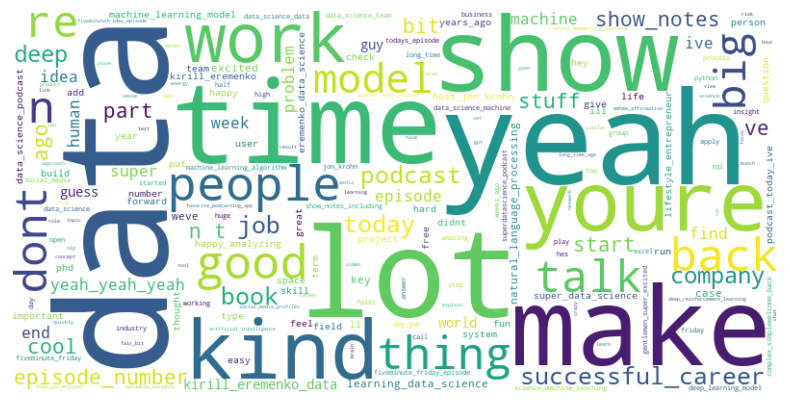

In [16]:

all_keywords = ' '.join(keywords_per_class.Document)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

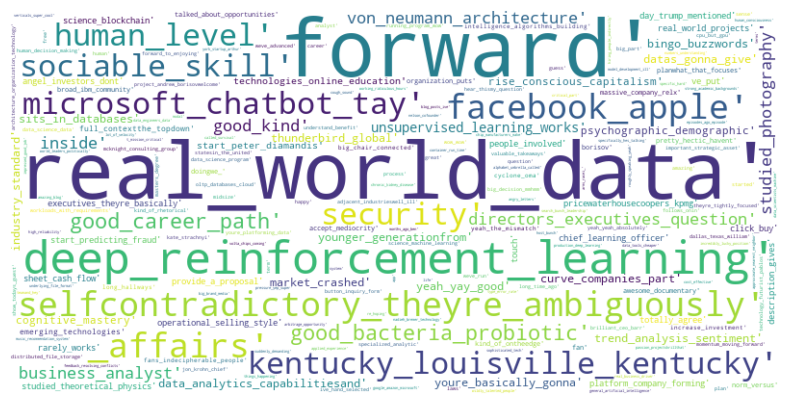

In [17]:
all_keywords = ' '.join(map(str, class_unique_20.unique_Words))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Function to generate 100 keywords per episode using Yake library if keywords need to be separate columns

def yake_keyword_extractor(doc):
    global sds_processed

    for i, episode_text in doc.iteritems():
        max_ngram_size = 3
        deduplication_threshold = 0.3
        windowSize = 1
        numOfKeywords = 100
        kw_extractor = yake.KeywordExtractor(n=max_ngram_size, dedupLim=deduplication_threshold, windowsSize=windowSize, top=numOfKeywords)
        keywords = kw_extractor.extract_keywords(episode_text)

        # Create separate columns for each keyword
        for j, keyword in enumerate(keywords):
            column_name = f'episode_keyword{j+1}'
            sds_processed.at[i, column_name] = keyword[0]  # Store the keyword value in the respective column

In [ ]:
def keyword_extractor(doc):
    kw_model = KeyBERT()
    global sds_processed
    stopwords = list(STOP_WORDS)
    
    for i, episode_text in doc.iteritems():
        keywords = kw_model.extract_keywords(episode_text, keyphrase_ngram_range=(1, 1), stop_words = stopwords, top_n = 100, use_mmr=True, diversity=0.7)
        sds_processed.at[i, 'episode_keywords'] = keywords

In [ ]:
# https://maartengr.github.io/BERTopic/index.html